In [23]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
retail = pd.read_excel('dataset/digikala_customer_orders.xlsx', sheet_name="orders")

In [3]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   order_id    200000 non-null  int64 
 1   user_id     200000 non-null  object
 2   variant_id  200000 non-null  int64 
 3   product_id  200000 non-null  int64 
 4   quantity    200000 non-null  int64 
 5   price       200000 non-null  int64 
 6   date        200000 non-null  object
 7   city_id     200000 non-null  int64 
 8   city_name   200000 non-null  object
 9   state_id    200000 non-null  int64 
 10  state_name  200000 non-null  object
dtypes: int64(7), object(4)
memory usage: 16.8+ MB


In [4]:
retail.describe()

,order_id,variant_id,product_id,quantity,price,city_id,state_id
count,2.000000e+05,2.000000e+05,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000
mean,2.603678e+08,8.194619e+05,386718.575000,1.327395,1.057300e+06,1829.737850,12.122495
std,9.014162e+05,4.162816e+05,212149.173524,1.428635,3.846753e+06,286.319633,7.045052
min,2.588380e+08,2.810000e+02,300.000000,-2.000000,1.000000e+00,1372.000000,2.000000
25%,2.595868e+08,4.835210e+05,191084.000000,1.000000,1.300000e+05,1698.000000,9.000000
50%,2.603573e+08,8.856180e+05,395477.000000,1.000000,2.900000e+05,1698.000000,9.000000
75%,2.610735e+08,1.181338e+06,568665.000000,1.000000,7.490000e+05,1905.000000,14.000000
max,2.621084e+08,1.495812e+06,789337.000000,100.000000,2.120000e+08,2613.000000,32.000000


In [5]:
retail.head()

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name
0,262108413,SlcW7YT835JSzh22o7zRCA==,922274,406523,1,139000,2018-08-20 23:59:02,1698,تهران,9,تهران
1,262108413,SlcW7YT835JSzh22o7zRCA==,685868,435013,1,890000,2018-08-20 23:59:02,1698,تهران,9,تهران
2,262108353,NZidrSuPdqoG7RedrFakeA==,275077,163947,1,9890000,2018-08-20 23:58:39,1698,تهران,9,تهران
3,262108341,dLQImlfXMsgSub4OcfJpGg==,679393,158560,1,349000,2018-08-20 23:58:35,1855,مشهد,12,خراسان رضوی
4,262108293,O/xo6mGsu7adcgxofe+MdQ==,769096,479854,1,320000,2018-08-20 23:58:28,1698,تهران,9,تهران


In [6]:
# shape of df
retail.shape

(200000, 11)

In [7]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

order_id      0.0
user_id       0.0
variant_id    0.0
product_id    0.0
quantity      0.0
price         0.0
date          0.0
city_id       0.0
city_name     0.0
state_id      0.0
state_name    0.0
dtype: float64

above section shows , there haven't null value :) hora

In [8]:
retail.columns  #df culumns name 

Index(['order_id', 'user_id', 'variant_id', 'product_id', 'quantity', 'price',
       'date', 'city_id', 'city_name', 'state_id', 'state_name'],
      dtype='object')

In [9]:
retail['user_id']= retail['user_id'].astype(str)

## Step 2: Data Preparation

We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [10]:
# New Attribute : Monetary

retail['Amount']= retail['quantity']*retail['price']
rfm_m = retail.groupby('user_id')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,user_id,Amount
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000
1,++HwHhPvBHtXEIN36fDT5w==,1414000
2,++IfjhhQ33j7i4NHdBUJkQ==,990000
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500
4,++XCbp2ChGJyYhM/fYWudg==,1150000


In [11]:
# New Attribute : Frequency

rfm_f = retail.groupby('user_id')['order_id'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['user_id', 'Frequency']
rfm_f.head()

,user_id,Frequency
0,++2u4Q40bTeC0ZZDau1MIQ==,3
1,++HwHhPvBHtXEIN36fDT5w==,6
2,++IfjhhQ33j7i4NHdBUJkQ==,1
3,++KPSp+1ZC6KXlYAS8VcKg==,15
4,++XCbp2ChGJyYhM/fYWudg==,1


In [12]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='user_id', how='inner')
rfm.head()

,user_id,Amount,Frequency
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000,3
1,++HwHhPvBHtXEIN36fDT5w==,1414000,6
2,++IfjhhQ33j7i4NHdBUJkQ==,990000,1
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500,15
4,++XCbp2ChGJyYhM/fYWudg==,1150000,1


In [13]:
# New Attribute : Recency
# Convert to datetime to proper datatype
retail['date'] = pd.to_datetime(retail['date'],format='%Y-%m-%d %H:%M:%S')

In [14]:
# Compute the maximum date to know the last transaction date
max_date = retail['date'].max()
max_date

Timestamp('2018-08-20 23:59:02')

In [15]:
# Compute the minimum date to know the last transaction date
min_date = retail['date'].min()
min_date

Timestamp('2018-08-12 06:19:19')

In [16]:
f"this df show orders for {max_date - min_date}"


'this df show orders for 8 days 17:39:43'

In [17]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['date']
retail.tail()

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name,Amount,Diff
199995,258838077,chbca7XuHDG/7OJPls3fNA==,494706,340247,1,40000,2018-08-12 06:21:26,1698,تهران,9,تهران,40000,8 days 17:37:36
199996,258838077,chbca7XuHDG/7OJPls3fNA==,823091,389988,1,325000,2018-08-12 06:21:26,1698,تهران,9,تهران,325000,8 days 17:37:36
199997,258838077,chbca7XuHDG/7OJPls3fNA==,483089,334477,1,1750000,2018-08-12 06:21:26,1698,تهران,9,تهران,1750000,8 days 17:37:36
199998,258838077,chbca7XuHDG/7OJPls3fNA==,1129695,640539,1,184000,2018-08-12 06:21:26,1698,تهران,9,تهران,184000,8 days 17:37:36
199999,258838041,OVCXfcaxQtqLzmy1U8A7eg==,1033353,568751,1,170000,2018-08-12 06:19:19,1442,بوکان,3,آذربایجان غربی,170000,8 days 17:39:43


In [18]:
# Compute last transaction date to get the recency of customers
rfm_p = retail.groupby('user_id')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,user_id,Diff
0,++2u4Q40bTeC0ZZDau1MIQ==,0 days 13:01:16
1,++HwHhPvBHtXEIN36fDT5w==,1 days 23:45:53
2,++IfjhhQ33j7i4NHdBUJkQ==,7 days 03:09:40
3,++KPSp+1ZC6KXlYAS8VcKg==,6 days 21:06:59
4,++XCbp2ChGJyYhM/fYWudg==,8 days 15:56:39


In [19]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,user_id,Diff
0,++2u4Q40bTeC0ZZDau1MIQ==,0
1,++HwHhPvBHtXEIN36fDT5w==,1
2,++IfjhhQ33j7i4NHdBUJkQ==,7
3,++KPSp+1ZC6KXlYAS8VcKg==,6
4,++XCbp2ChGJyYhM/fYWudg==,8


In [20]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='user_id', how='inner')
rfm.columns = ['user_id', 'Amount', 'Frequency', 'Recency']
rfm.head()

,user_id,Amount,Frequency,Recency
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000,3,0
1,++HwHhPvBHtXEIN36fDT5w==,1414000,6,1
2,++IfjhhQ33j7i4NHdBUJkQ==,990000,1,7
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500,15,6
4,++XCbp2ChGJyYhM/fYWudg==,1150000,1,8


In [36]:
rfm.shape

(54633, 4)

Text(0.5, 0, 'Attributes')

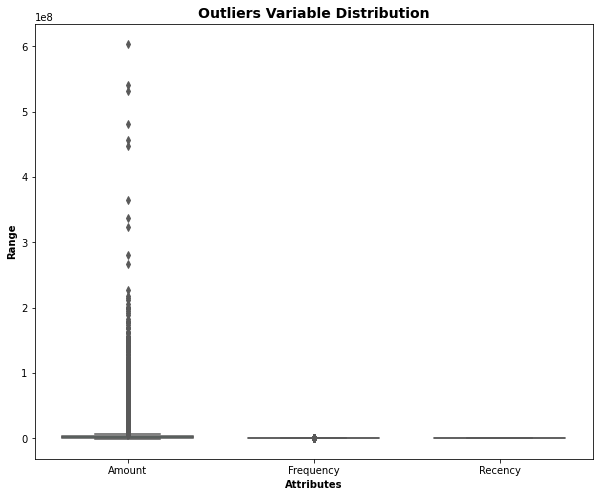

In [22]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

In [32]:
# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

In [33]:
# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

## Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.| There are two common ways of rescaling:

- Min-Max scaling
- Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [34]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(54633, 3)

In [37]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.481973,-0.085434,-1.380492
1,-0.398331,0.838648,-1.001254
2,-0.505151,-0.701489,1.274168
3,-0.328671,3.610895,0.894931
4,-0.464841,-0.701489,1.653405


## Step 3 : Building the Model

### K-Means Clustering
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [38]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [39]:
kmeans.labels_

array([3, 3, 2, ..., 3, 2, 0])

### Finding the Optimal Number of Clusters

**Elbow Curve to get the right number of Clusters** 

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

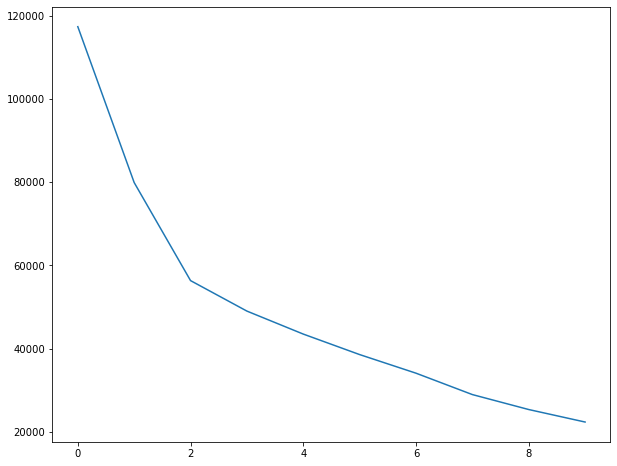

In [42]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 10, 12 , 14, 16, 18, 20]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

**Silhouette score = (p-q)/max(p,q)**

 **P** is the mean distance to the points in the nearest cluster that the data point is not a part of

 **q** is the mean intra-cluster distance to all the points in its own cluster.

- The value of the silhouette score range lies between -1 to 1.

- A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.



In [43]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 10, 12 , 14, 16, 18, 20]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.47037625141743605
For n_clusters=3, the silhouette score is 0.40077218796455355
For n_clusters=4, the silhouette score is 0.4333970006421875
For n_clusters=5, the silhouette score is 0.42154203065874746
For n_clusters=6, the silhouette score is 0.4228688835612002
For n_clusters=7, the silhouette score is 0.3982951425868472
For n_clusters=8, the silhouette score is 0.3493980318609136
For n_clusters=10, the silhouette score is 0.35367754940792
For n_clusters=12, the silhouette score is 0.31441343602423694
For n_clusters=14, the silhouette score is 0.32380544147857404
For n_clusters=16, the silhouette score is 0.32882602721513843
For n_clusters=18, the silhouette score is 0.3313403082474523
For n_clusters=20, the silhouette score is 0.30943247715683464


In [45]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [46]:
 kmeans.labels_

array([2, 2, 1, ..., 2, 1, 0])

In [48]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,user_id,Amount,Frequency,Recency,Cluster_Id
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000,3,0,2
1,++HwHhPvBHtXEIN36fDT5w==,1414000,6,1,2
2,++IfjhhQ33j7i4NHdBUJkQ==,990000,1,7,1
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500,15,6,0
4,++XCbp2ChGJyYhM/fYWudg==,1150000,1,8,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

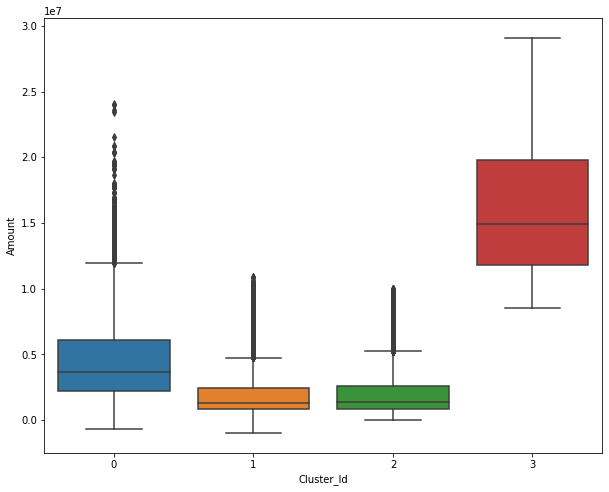

In [49]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

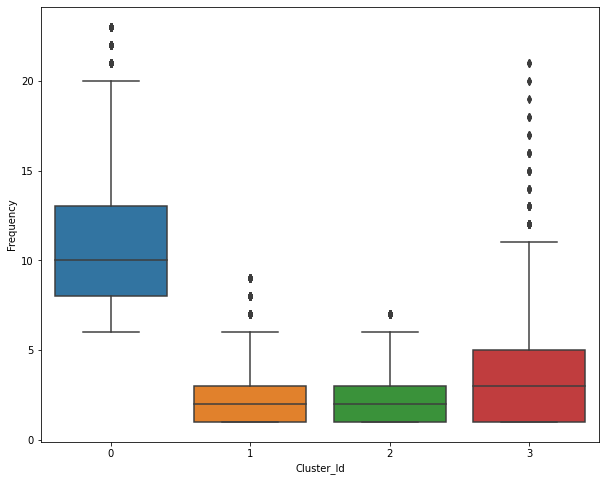

In [50]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

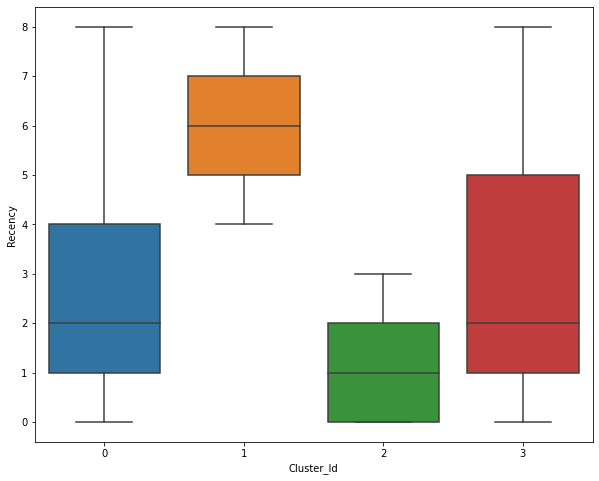

In [51]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

## Step 5 : Final Analysis

**Inference:**
K-Means Clustering with 4 Cluster Ids

- Customers with Cluster Id 3 are the customers with high amount of transactions -as compared to other customers.
- Customers with Cluster Id 0 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.
